# Processing of particle tracks 
### <font color='gray'>coded to work with experiments and simulation</font>

## _Import of python libraries used within the code_

### <font color ='gray'> load both code cells  </font>  

In [1]:
#HI HELLO
import numpy as np # fast array library
import pandas as pd # data frames library
# plot display type. use this to keep graphs within the notebook
import matplotlib


import matplotlib.pyplot as plt # plot library

import subprocess # these 2 lines below load OS functionality
import sys
import json

from IPython.display import display, HTML # screen on display in HTML library 

import sympy as sp # symbolic calculation library functions
from sympy import var # symbolic calculation library variables

import mpmath as mp # double (or higher) floating point precision library (not used)

import scipy.constants as ct # import mathematical constants
import scipy.special as spec
from scipy.spatial import Voronoi, voronoi_plot_2d # import Voronoi functions
import scipy.optimize as optimize # optimazation library (not used)
from scipy import signal # noise filtering functions
from scipy import stats # statistics, for binning and fields calculation
from scipy.spatial import Voronoi, voronoi_plot_2d # import Voronoi functions

import ipywidgets as widgets # import 

from collections import Counter # (not used)
import time # timing functions (for computation time)

global iscaled 
iscaled = 0

global LX, LY
LX = 1000 -250
LY = 650-50

# system size for a given (npart, rho) configuration
def L(npart, rho):
    l = np.sqrt(npart*2*np.sqrt(3.)/rho)
    return l

# print progress function
# more elegant (python 3 alternative): print('\rhello', end='',flush=True)
def printp(string):
    sys.stdout.write('\r'+ str(string))
    sys.stdout.flush()
    
#from __future__ import print_function

# Text format for figures configuration (lines below)
from matplotlib import rc
rc('text', usetex=True)
plt.rcParams['font.size'] = 14
# special plotting functions
from matplotlib.collections import PolyCollection
import matplotlib.colors as mcolors

def set_up_graf(idf, LX, LY):
    global ax, fig_system, ss

    fig_system = plt.figure(idf, figsize=(6.5,6.5*LY/LX))
    ss=(72./fig_system.dpi)**2 # particle size
    ax = fig_system.add_subplot(1, 1, 1)
    ax.set_ylim([0,LY])
    ax.set_xlim([0,LX])
    ax.set_xlabel(r'$x/\sigma$',fontsize = 14)
    ax.set_ylabel(r'$y/\sigma$', fontsize = 14)


In [2]:
%matplotlib --list

Available matplotlib backends: ['tk', 'gtk', 'gtk3', 'wx', 'qt4', 'qt5', 'qt', 'osx', 'nbagg', 'notebook', 'agg', 'svg', 'pdf', 'ps', 'inline', 'ipympl', 'widget']


In [2]:
# matplotlib widgets interface
%matplotlib inline 
# tk interface
#%matplotlib tk 

## _Read tracking data_ 

We explain the action of each of these functions below:

__get_info(hash_prefix) :__ Reads and prints info file with  _hash prefix_ hash code. See output table in <font color='red' >RUN CELL 0</font> below to grasp the info structure

__simple_pickle_read(hash_prefix) :__
This 'simple_pickle_read' takes a pkl.xz file _hash prefix_ hash code, and which contains xy positions and tracks (no velocities) and stores in 'tabla' pandas data frame.
   
  * input: hash_prefix
  * output: global variable _Ntracks_ (number of tracks) 

In [11]:
def pdisplay(info):
    display(HTML(info.to_html()))

# This function reads pickle binary file (.pkl) with trajectories
def get_info(series_directory, hash_prefix):
    global info
    nombre = '/home/fvega/Datos/blades/info_files/' + hash_prefix + '.txt'
    with open(nombre) as f:
        jsonstr = json.load(f)
    info = pd.json_normalize(jsonstr)
    pdisplay(info.T)
    return info
    
def simple_pickle_read(series_directory, hash_prefix):
    global Nframes, Ntracks
    # Read table in pickle format
    nombre = '/home/fvega/Datos/blades/' + series_directory +  hash_prefix \
       + '.pkl.xz'
    tabla = pd.read_pickle(nombre, compression='infer')
    tabla = tabla.reset_index(drop=True) # por si los indices salen desordenados
    Nframes = np.max(tabla.frame)
    Ntracks = np.max(tabla.track)+1
    tabla = tabla.sort_values(by = ['frame', 'track']).reset_index(drop=True)
    return tabla

## _Reduce global table - functions_

__reset_track_indexes(tabla0):__ 
Eliminates 'lonely' tracks (particles tracked for just 1 frame), re-indexes so that no track indexes are empty
* input: _tabla0_ original data frame (of tracks)
* output: RETURNS clean _tabla_ data frame, without empty tracks; AND original _tabla0_ with empty tracks still included
* output structure: _tabla0_, _tabla_

__short_drop:(ishort, tabla):__ 
Eliminates tracks detected for n frames or less, re-indexes so that no track indexes are empty

* Input: _ishort_ (threshold length of tracks: shorter tracks are not kept), _tabla_ (original tracks data frame)

* Output: RETURNS _tabla_\__short_ (frame), that is the input table _tabla_ without tracks shorter than _ishort_


In [4]:
def reset_track_indexes(tabla0):
    global Ntracks, Nframes
    """ This function takes a dataframe in which some trajectory indexes
        are missing (maybe due to having deleted short trajectories) and
        resets indexes so that we can loop over the tracks with 'range' """
    # 'real_number_of_tracks' should be <=  than 'current_last_particle_index'
    tabla = tabla0.copy()
    Ntracks = len(set(tabla.track))
    original_indexes = np.sort(list(set(tabla.track)))
    unsort_indexes = original_indexes
    fixed_indexes = np.arange(0, Ntracks, step=1, dtype=int)
    if  (original_indexes == fixed_indexes).all()==False: # fix only if there are empty tracks
    # With these two lists we create a dictionary and map old values to new ones
        n_empty = np.max(tabla.track) - Ntracks
        replacement_dict = dict(zip(original_indexes, fixed_indexes))
        tabla.track = tabla.track.map(dict(zip(original_indexes, fixed_indexes)))
        print('no. of empty track indexes discarded: ', n_empty, '\n')
    else:
        print('nothing to fix\n')
    Ntracks = np.max(tabla.track)+1
    Nframes = np.max(tabla.frame)
    return tabla0, tabla

# INPUT
# ishort: number of minimum frames in a track (eliminates tracks under ishort time length)
# tabla: pandas Data Frame to shorten
# OUTPUT
def short_drop(ishort, tabla):
    global shorts_list, Ntracks
    shorts_list =[]
    Ntracks = np.max(tabla.track)+1
    for i in range(Ntracks):
        t1 = track(i,tabla,False)
        if  len(t1) < ishort+1:
            shorts_list.append(i)
            len0 = len(tabla)
            tabla = tabla.drop(t1['index'])
            texto = 'dropped track no. '+str(i)+'; data table length decreased in '+str(len(tabla)-len0)
            printp(texto)
    print('\n')
    tabla_short = tabla.sort_values(by = ['frame', 'track']).reset_index(drop=True)
    Nshorts = np.max(tabla_short.track)+1
    printp('Dropped out ' + str(Ntracks-Nshorts)+' short tracks out of ' + str(Ntracks))
    # the line above is necessary so that eliminates index voids and shuffling after short drop
    print('\n')
    return tabla_short


## _Get tracks and states from global table - functions_

__track(t_id, tabla, dropit) :__  builds track for one particle from the appropriate chunk of the source table, with only the lines for particle _t_\__id_ 

* Input: _t_\__id_ indice de track, _tabla_ source frame fuente (contains tracks), _dropit_ boolean; if =True then erases old index column (tracks do not always begin in frame 0); most of the time you just want _dropit_=True

* Output: RETURNS a chunk of source table _tabla_ with only the lines for particle _t_\__id_

__all\___ __tracks(tabla, dropit):__ repeats the process in _track_ function for all existing particles

* Input: _tabla_ (frame) data source, _dropit_ boolean variable set True to erase original table original line number

* Output: RETURNS _track_ array of frames each wiith one particle track; builds _tr_\__lengths_ array of tracks lengths


__state(it, tabla):__ gets one instantaneous state frome source frame _tabla_, at frame _it_

* Input: _it_ frame no. to get the state from; _tabla_ source frame data

* Output: RETURNS st frame chunk from _tabla_ source frame

__all__\___states(tabla):__ Builds all instantaneous states from the movie

* Input: _tabla_ source frame data

* Output: RETURNS array of frame chunks from _tabla_ source frame. each chunk being an instantaneous state

In [5]:
#####  INDIVIDUAL TRACKS ##############
# build a 't_id' indivitual track 
def trackf(t_id, tabla, dropit):
    t1 = tabla.loc[tabla.track == t_id].reset_index(drop=dropit)
    return t1

# build individual tracks from all kept tracks
# OUTPUT
# tr_lengths[i]: length of track no.  'i'. The total no. of tracks is stored in 'Ntracks'
def all_tracks(tabla,dropit):
    # length of track
    global tr_lengths
    tr_lengths = np.empty(Ntracks,dtype=int)
    tracks = [[] for i in range(Ntracks)]
    for i in range(Ntracks):
        tracks[i] = trackf(i,tabla,dropit)
        tr_lengths[i] = int(len(tracks[i]))
    return tracks

#####  INSTANTANEOUS STATES  ##############
# BUILD INSTANTANEOUS STATES OF THE SYSTEM
def state(it, tabla):
    st = tabla.loc[tabla.frame == it].reset_index(drop=True)
    # reset row index 
    #(otherwise keeps chunked index of the original table)
    return st

# build instantaneous states over all frames
def all_states(tabla):
    sts = [[] for i in range(Nframes)]
    for i in range(Nframes):
        sts[i] = state(i,tabla)
    return sts


## Bring data to physical units

We take as coordinate origin the mid-point of the max and min X and Y positions ever tracked within the region of interest (ROI) during the experiment.

We have 2 options for lengh unit: 
* milimeters 
* Ball diameter

The time scale unit is seconds.

Only after this step position differences in the original data table are re-scaled as real velocities

In [6]:
# PHYSICAL SCALES AND ORIGIN
# Usage: re_pos_scale(0) for 1 mm as length unit; re_pos_scale(1) for ball diameter (sigma) 
# length unit

def set_origin(shiftx, shifty, tabla):
    global ishifted 
    if ishifted == 0:
        tabla_not_shifted = tabla.copy()
        tabla.loc[:,'x'] = tabla.x.values - shiftx
        tabla.loc[:,'y'] = tabla.y.values - shifty
        shifted = 1
    return tabla_not_shifted, tabla


def scale(l_factor, t_factor, tabla):
    global iscaled
    tabla_not_scaled = tabla.copy()
    if iscaled == 0:
        if np.any(tabla.columns=='vx') or np.any(tabla.columns=='vy'):
            tabla[['x','y']] *= l_factor
            tabla[['vx', 'vy']] *= (l_factor / t_factor)
            if np.any(tabla.columns=='ax') or np.any(tabla.columns=='ay'):
                tabla[['ax', 'ay']] *=  (l_factor * t_factor**2)
        else:
            tabla[['x','y']] *= l_factor
        iscaled = 1
    else:
        tabla[['x','y']] *= 1
        iscaled = 1
    return tabla_not_scaled, tabla


## Processing of blades angles

The process has the following steps:
 
* Eliminating blades with angles: $\theta_i >2 \pi$
* Storing angle list length
* Interpolating missing angles for those lists with angles length < no. of blades

In [7]:
# save max and/or min angles and re-scale angle unit
circ_unit = 14 # NUMBER OF BLADES IN PARTICLES

# SCALE ANGLES TO blades
def save_rescale_angle(imin, tabla):
    ln = len(tabla)
    maxs = np.array([tabla.extremos[i][0] for i in range(ln)]) # keeps angle maxima
    maxs = circ_unit*(maxs/360)
    datos['maxt'] = maxs # transforms angle into blade units
    if imin != 0:
        mins = np.array([datos.extremos[i][1] for i in range(ln)])   
        mins = circ_unit*(mins/360)
        datos['mint'] = mins


# deletes blades beyond the forteenth blade (the last one in this case) + 1/2 blade
def filter_spurious_angles(imin,tabla):
    for i in range(len(tabla)):
        tabla.at[i,'maxt'] = np.array(list(filter(lambda x: x<(circ_unit+0.5), tabla.maxt[i])))
    if imin != 0:
        for i in range(len(tabla)):
            tabla.at[i,'mint'] = np.array(list(filter(lambda x: x<(circ_unit+0.5), tabla.mint[i])))
            

def filter_outside_blades(tabla):
    for i in range(len(tabla)):       
        try:
            #np.where(tabla.maxt[i]>14)[0][0]
            lista =  np.where(tabla.maxt[i]>14)[0]
            if len(tabla.maxt[i]) > 15:
                print("DANGER! DANGER! DANGER!\n")
            if len(tabla.maxt[i]) > 14: 
                for k in lista:
                    tabla.at[i,'maxt'] = np.delete(tabla.at[i,'maxt'],k) 
                    # deletes outside blades (+1/2) if list length > 14
            else:
                for k in lista:
                    tabla.at[i,'maxt'][k] = tabla.at[i,'maxt'][k] - 14
                    a = tabla.maxt[i][k]
                    tabla.at[i,'maxt'] = np.delete(tabla.maxt[i], k) 
                    # substract nblades to outside blades if list length < 14
                    tabla.at[i,'maxt'] = np.insert(tabla.maxt[i], 0, a)
                    # place it at the beginning of the list
        except:
            pass


# Deletes one excess element in maxima arrays
# based on  closest to 1 difference (between first and last pair)
def last_del15(tabla,larr):
    if len(np.where(larr==15)[0])>0:
        for i in np.where(larr==15)[0]:
            arr = tabla.maxt[i]
            if (np.abs(arr[1]-arr[0]-1) < np.abs(arr[14]-arr[13] -1)):
                tabla.at[i,'maxt'] = np.delete(arr,-1)
            else:
                tabla.at[i,'maxt'] = np.delete(arr,0)


# Stores in a list the angles lists lengths; of either maxt or mint (not simultaneously)
def angles_list_lengths(arr):
    la = []
    for i in arr:
        la.append(len(i))
    la = np.array(la).astype(int)
    return la


# insert_missing: 
# detects missing blades, linearly interpolates them
def insert_missing(tabla, larr):
# PROCEDIMIENTO PARA INTERPOLAR listas de maximos con menos de 14 maximos
    while len(np.where(larr==13)[0]) > 0:
        interpolated_indexes = np.zeros(len(np.where(larr==13)[0]))
        for i in np.where(larr < 14)[0]:
            diff_arr = tabla.maxt[i][1:] - tabla.maxt[i][:-1]
            imax = np.where(diff_arr == np.max(diff_arr))[0][0] # maximum index
            interpolated_indexes = np.append(interpolated_indexes, imax)
            tabla.at[i,'maxt'] = np.insert(tabla.maxt[i], imax+1, 0.5 * (tabla.maxt[i][imax] + tabla.maxt[i][imax+1]))
        larr = angles_list_lengths(datos.maxt)
    print('done\n')



## return_next: 
### finds angle location of a reference blade (j0) in next frame jt+1, within track no. itr
__input__ : _itr_ (track no.), _jt_ (reference frame no.), _j0_ (reference blade)

In [8]:
nblades = circ_unit

def return_next(itr,jt,j0):
    
    list_its = [j0, j0-1, j0+1]
    
    theta0 = tracks[itr].maxt[jt][j0]
    # by default, angle difference is with itself in the next frame
    diff0 = tracks[itr].maxt[jt+1][j0] - theta0 # ldiff0, rdiff0
    
    if (j0==0):
        ldiff = tracks[itr].maxt[jt+1][nblades-1] - theta0 - circ_unit 
        list_its[1] = nblades-1
    else:
        ldiff = tracks[itr].maxt[jt+1][j0-1] - theta0 
        
    if (j0==nblades-1):
        rdiff = tracks[itr].maxt[jt+1][0] - theta0 + circ_unit
        list_its[2] = 0
    else:
        rdiff = tracks[itr].maxt[jt+1][j0+1] - theta0
    
    list_diffs = [diff0, ldiff, rdiff]

    inm = np.where(np.abs(list_diffs) == np.min(np.abs(list_diffs)))[0][0] 
    
    in0 = list_its[inm]
    diffnext0 = list_diffs[inm]

    return in0, diffnext0


def shift_back(itr,jt,n0):
    arr_copy = np.zeros(nblades)
    for i in range(n0,nblades):
        arr_copy[i-n0] = tracks[itr].maxt[jt][i]
    for i in range(0,n0):
        arr_copy[(nblades-1)-(n0-1)+i] = tracks[itr].maxt[jt][i]
    return arr_copy


## <font color='RED'>RUN CELL 0</font>
### - Import pkl.xz tracks table
### - create all individual tracks arrays
### - analyze track length histogram, decide minimum track length

In [207]:
# COMPLETE SET OF READING INSTRUCTIONS

series_directory = 'rho_025/relleno_mapa_fases/' # series directory. KEEP THE FINAL / 
hash_prefix = '69dfd93d44de3a79297788beedb712de'

print('data reading and basic processing\n')

info = get_info(series_directory, hash_prefix)

datos = simple_pickle_read(series_directory, hash_prefix)
datos_orig, datos = reset_track_indexes(datos)

##datos = datos[['frame','track','x','y','extremos']]
datos = datos[['frame','track','x','y']]
#
#save_rescale_angle(0, datos)
#
#del datos['extremos'] # remove original clumpsy angles list structure
##datos.columns = ['frame','track','x','y','maxs','mins'];


# imprime (formateada) cabecera de tabla de datos
pdisplay(datos.head())


print('\n min for positions:\n', np.min(datos[['x','y']]), '\n')
print('max. for positions:\n', np.max(datos[['x','y']]), '\n')
print('\n average for x,y positions:\t', np.mean(datos.x), np.mean(datos.y), '\n')


############### COMMENT THIS SECTION IF CALCULATE SPINS ##########
print('storing all tracks (maxima arrays corrected)')
# store tracks individually
tracks = all_tracks(datos, True)
##################################################################

#############  begin SPIN PART (comment for 250 fps tracks) ###################

#print('filtering spurious angles \n')
#filter_spurious_angles(0,datos)
#
#la = angles_list_lengths(datos.maxt)
#
##plt.figure(figsize=(8,8/ct.golden))
##plt.hist(la,rwidth=0.96, bins=[11,12,13,14,15,16,17],color='r',density=True,align='left')
#
#
#print('filtering close outside blades\n')
#filter_outside_blades(datos)
#
#la = angles_list_lengths(datos.maxt)
#
#plt.figure(figsize=(8,8/ct.golden))
#plt.hist(la,rwidth=0.96, bins=[5,6,7,8,9,10,11,12,13,14,15,16,17],color='r',density=True,align='left');
#
#
#print('delete last arrays with one excess blades (last one is < (nblades+1/2 blade) )\n')
#last_del15(datos,la)
#
#la = angles_list_lengths(datos.maxt)
#
#plt.figure(figsize=(8,8/ct.golden))
#plt.hist(la,rwidth=0.96, bins=[5,6,7,8,9,10,11,12,13,14,15,16,17],color='r',density=True,align='left');
#
#print('interpolating missing maxima\n')
#insert_missing(datos, la)
#
#la = angles_list_lengths(datos.maxt)
#
#plt.figure(figsize=(8,8/ct.golden))
#plt.hist(la,rwidth=0.96, bins=[5,6,7,8,9,10,11,12,13,14,15,16,17],color='r',density=True,align='left');
#
#
#
#print('storing all tracks (maxima arrays corrected)')
## store tracks individually
#tracks = all_tracks(datos, True)
#
#
#print(np.where(la!=14))
#print('14-blades max angle lists ready')
#
#
##Ntracks = 10
#
## reposition angles so that each position in the angle array is each moving blade
## obtain spins (omega) from there
#theta = np.zeros((Ntracks,Nframes), dtype=float)
#omega = np.zeros((Ntracks,Nframes), dtype=float)
#

#for j in range(Ntracks):
#    ln = len(tracks[j])
#    theta[j][0] = np.mean(tracks[j].maxt[0]- np.arange(circ_unit))
#    ianext, omega[j][0] = return_next(j, 0, 0)
#    for i in range(1,ln-1):
#        if (i%500)==0:  printp('track no. ' + str(j+1)+ ' of ' + str (Ntracks) + ', frame ' + str(i)+ ' of ' + str(Nframes-2))
#        theta[j][i] = np.mean(tracks[j].maxt[i]- np.arange(-ianext ,circ_unit -ianext))
#        ianext, omega[j][i] = return_next(j, i , ianext)
#    theta[j][ln-1] = np.mean(tracks[j].maxt[ln-1]- np.arange(-ianext ,circ_unit -ianext))   
#    
#plt.figure()
#plt.hist(omega[0],bins=200);


#############  end SPIN PART (end of comment for 250 fps tracks) ###################

Ntracks=25

for i in range(Ntracks):

    # store angular part in tracks # comment for 250 fps tracks
    #tracks[i]['theta'] = theta[i][:len(tracks[i])]
    #tracks[i]['w'] = omega[i][:len(tracks[i])]
    #tracks[i] = tracks[i].drop('maxt', axis=1)

    # velocities
    diffsx = tracks[i].x[1:].values - tracks[i].x[:-1].values
    diffsy = tracks[i].y[1:].values - tracks[i].y[:-1].values
    tracks[i] = tracks[i].drop(len(tracks[i])-1)
    tracks[i]['vx'] = diffsx
    tracks[i]['vy'] = diffsy
    
    # accelerations
    adx = tracks[i].vx[1:].values - tracks[i].vx[:-1].values
    ady = tracks[i].vy[1:].values - tracks[i].vy[:-1].values
    tracks[i] = tracks[i].drop(len(tracks[i])-1)
    tracks[i]['ax'] = adx
    tracks[i]['ay'] = ady
    
    #tracks[i] = tracks[i][['frame', 'track', 'x', 'y', 'vx', 'vy', 'ax', 'ay', 'theta','w']]
    tracks[i] = tracks[i][['frame', 'track', 'x', 'y', 'vx', 'vy', 'ax', 'ay']] # no spin

    
datos = tracks[0] # this is necessary because we derive v's and ws from tracks

for i in range(1,Ntracks):
    datos = datos.append(tracks[i])

# image_flip_y
datos.loc[:,'y'] = info['shape'].values[0][1] - datos.y.values
# image_flip_vy
datos.loc[:,'vy'] = -datos.vy.values

datos.sort_values(by = ['track', 'frame']).head()

## redefine angle after flip to rad
##datos.theta = np.pi - datos.theta
#
## set coordinates origin
#ishifted = 0
#datos_orig, datos = set_origin(395,669, datos)
#iscaled = 0
#datos_orig, datos = scale(100*info.particle_diameter_m[0]/info.particle_diameter_px[0], 1/info.fps[0], datos)
#datos.theta = (2 * np.pi) * datos.theta / circ_unit
#datos.w = (2* np.pi) * datos.w /circ_unit

pdisplay(datos.head())


datos.loc[:,'vx'] = signal.savgol_filter(datos.vx.values, 5,3)
datos.loc[:,'vy'] = signal.savgol_filter(datos.vy.values, 5,3)

datos.head()



data reading and basic processing



,0
experiment_id,69dfd93d44de3a79297788beedb712de
original_file,D:/serieAspas/relleno_mapa_fases2\serieAspas_N25_p245_fps250_Y20201218_H103858.cine
date,2020-12-18 10:38:58
shape,"[1280, 800]"
fps,250
exposure,1500
n_frames,24981
recording_time,99.924
camera_distance,0.924
pixel_ratio,1020.69


nothing to fix



,frame,track,x,y
0,1,0,839.598514,626.231945
1,1,1,665.996865,79.205199
2,1,2,758.531316,107.201127
3,1,3,877.447135,145.401130
4,1,4,787.100719,192.804556



 min for positions:
 x    324.164443
y     53.983665
dtype: float64 

max. for positions:
 x    987.791786
y    717.618127
dtype: float64 


 average for x,y positions:	 651.1580957843165 387.7713123284041 

storing all tracks (maxima arrays corrected)


,frame,track,x,y,vx,vy,ax,ay
0,1,0,839.598514,173.768055,-0.082915,-0.089303,-0.137386,0.023695
1,2,0,839.515599,173.678752,-0.220300,-0.112998,0.019939,0.019001
2,3,0,839.295298,173.565754,-0.200362,-0.131999,-0.103841,-0.104384
3,4,0,839.094937,173.433755,-0.304203,-0.027615,-0.039277,-0.020689
4,5,0,838.790734,173.406140,-0.343480,-0.006927,-0.006963,-0.020076


/usr/lib/python3/dist-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


,frame,track,x,y,vx,vy,ax,ay
0,1,0,839.598514,173.768055,-0.089621,-0.084649,-0.137386,0.023695
1,2,0,839.515599,173.678752,-0.193475,-0.131613,0.019939,0.019001
2,3,0,839.295298,173.565754,-0.240600,-0.104076,-0.103841,-0.104384
3,4,0,839.094937,173.433755,-0.285295,-0.052486,-0.039277,-0.020689
4,5,0,838.790734,173.406140,-0.342469,-0.006824,-0.006963,-0.020076


# Fields calculation

In [208]:
R = 400
limits = [[-R, R], [- R, + R]]
xc = 656
yc = 395 

x = datos.x.values - xc
y = datos.y.values - yc
NBIN = 15

Y, X = np.mgrid[ 400 - R:400 + R:NBIN*1j,xc - R:xc + R:NBIN*1j]
X = X - xc
Y = Y - yc

ux = stats.binned_statistic_2d(x, y, datos.vx.values, statistic='mean', bins=NBIN, range=limits)[0].T
uy = stats.binned_statistic_2d(x, y, datos.vy.values, statistic='mean', bins=NBIN, range=limits)[0].T 

speed = np.sqrt(ux**2 + uy**2)

for i in range(NBIN):
    for j in range(NBIN):
        if np.isnan(ux[i][j]) == True:
            ux[i][j] = 0 
            uy[i][j] = 0

n = stats.binned_statistic_2d(x, y,1, statistic='count', bins=NBIN, range=limits)[0].T
n = (n/Nframes)/(info.N[0]/NBIN)

T = stats.binned_statistic_2d(x, y, datos.vx.values, statistic='std', bins=NBIN, range=limits)[0].T**2 + \
stats.binned_statistic_2d(x, y, datos.vy.values, statistic='std', bins=NBIN, range=limits)[0].T**2

/usr/lib/python3/dist-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


In [218]:
Y[0]

array([-395., -395., -395., -395., -395., -395., -395., -395., -395.,
       -395., -395., -395., -395., -395., -395.])

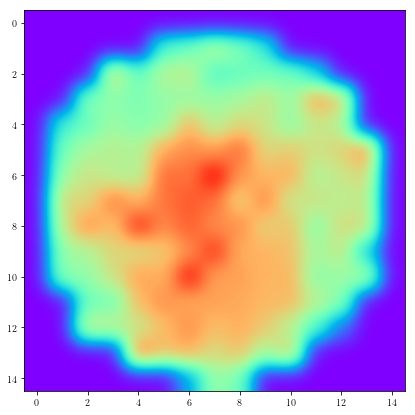

In [209]:
plt.figure(figsize=(7,7))
plt.imshow(T,cmap='rainbow', interpolation='gaussian')

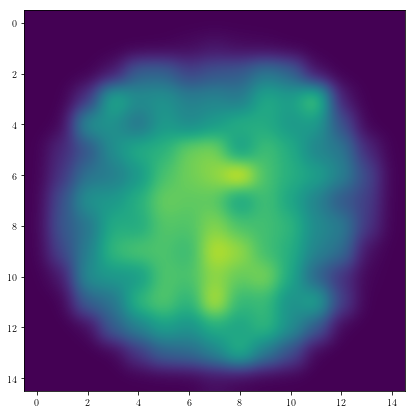

In [210]:
plt.figure(figsize=(7,7))
plt.imshow(T*n, interpolation='gaussian')

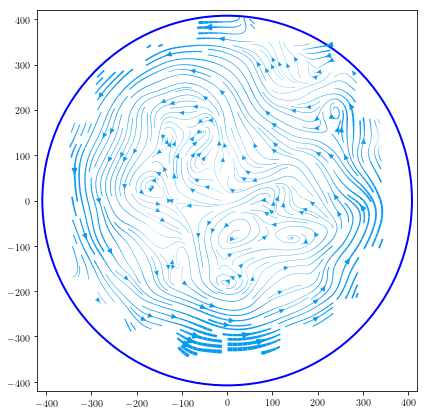

In [211]:
plt.close('all')
figure, axes = plt.subplots(figsize=(7,7))

draw_circle = plt.Circle((0, 0), 408, fill=False, color='b', linewidth=2)

axes.set_aspect(1)
axes.add_artist(draw_circle)

lw = 10* speed
plt.xlim(-420,420)
plt.ylim(-420,420)
plt.streamplot(X, Y, ux, uy, color='xkcd:azure', density=2.6, linewidth=lw)

In [1]:
fig, ax1 = plt.subplots(figsize=(7, 7))

dens = plt.imshow(n, interpolation='gaussian', cmap='gnuplot',extent=(-400,400,-400,400), 
                  vmax = np.max(n)*0.75,vmin=-0.005)

fig.colorbar(dens, ax=ax1,fraction=0.047, pad=0.01)

NameError: name 'plt' is not defined

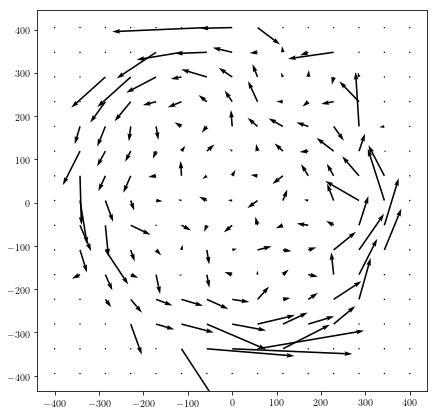

In [214]:
plt.close('all')
plt.figure(figsize=(7,7))
plt.quiver(X,Y,ux,uy)

In [216]:
archivo = open("fields_N25_T171.dat", "w")

d1, d2 = np.shape(X)

archivo.write("{0: ^10s} {1: ^10s} {2: ^10s}{3: ^10s} {4: ^10s} {5: ^10s}".format("X", "Y", "T", "n", "ux", "uy"))
archivo.write("\n")
for i in range(d1):
    for j in range(d2):
        archivo.write('{0:10.3f} {1:10.3f} {2:10.6f} {3:10.6f} {4:10.6f} {5:10.6f} \n'.format(\
                        X[i][j], Y[i][j], T[i][j], n[i][j], ux[i][j], uy[i][j] ))

archivo.close()

### Results for N=25, p=20

In [12]:
ux = np.mean(datos.vx.values)
uy = np.mean(datos.vy.values)
wm = np.mean(datos.w.values)
print(ux, '\t', uy, '\t', wm)

0.023849501822768595 	 -0.0172878306235344 	 0.056885224783797775


In [43]:
V2x = np.mean((datos.vx.values-ux)**2)
print(V2x)
V2y = np.mean((datos.vy.values-uy)**2)
print(V2y)
V2 = V2x + V2y

W2 = np.mean((datos.w-wm)**2)
print(W2)

32.35576596651159
33.73005290344488
0.0008486887613933535


In [55]:
V2W2 = np.mean(( (datos.vx.values-ux)**2 + (datos.vy.values -uy)**2 ) * (datos.w.values-wm)**2 )
print(V2W2)

0.05820488240859471


### Results for N=25, p=23

In [57]:
ux = np.mean(datos.vx.values)
uy = np.mean(datos.vy.values)
wm = np.mean(datos.w.values)
print(ux, '\t', uy, '\t', wm)

0.00850022569690806 	 0.06743688157076051 	 0.11620404907136958


In [58]:
V2x = np.mean((datos.vx.values-ux)**2)
print(V2x)
V2y = np.mean((datos.vy.values-uy)**2)
print(V2y)
V2 = V2x + V2y

W2 = np.mean((datos.w-wm)**2)
print(W2)

66.68274202904526
67.55854122556701
0.0005008372090996658


In [59]:
V2W2 = np.mean(( (datos.vx.values-ux)**2 + (datos.vy.values -uy)**2 ) * (datos.w.values-wm)**2 )
print(V2W2)

0.07107157593920019


### Results for N=25, p=25

In [61]:
ux = np.mean(datos.vx.values)
uy = np.mean(datos.vy.values)
wm = np.mean(datos.w.values)
print(ux, '\t', uy, '\t', wm)

0.04431854623711987 	 0.06198057832941791 	 0.14631597723746806


In [62]:
V2x = np.mean((datos.vx.values-ux)**2)
print(V2x)
V2y = np.mean((datos.vy.values-uy)**2)
print(V2y)
V2 = V2x + V2y

W2 = np.mean((datos.w-wm)**2)
print(W2)

109.43731755649304
119.74282738338087
0.0005040473913035043


In [63]:
V2W2 = np.mean(( (datos.vx.values-ux)**2 + (datos.vy.values -uy)**2 ) * (datos.w.values-wm)**2 )
print(V2W2)

0.20407641156995654


### Results for N=25, p=26

In [65]:
ux = np.mean(datos.vx.values)
uy = np.mean(datos.vy.values)
wm = np.mean(datos.w.values)
print(ux, '\t', uy, '\t', wm)

0.17619735928483632 	 0.40460723257092335 	 0.15724185460623522


In [66]:
V2x = np.mean((datos.vx.values-ux)**2)
print(V2x)
V2y = np.mean((datos.vy.values-uy)**2)
print(V2y)
V2 = V2x + V2y

W2 = np.mean((datos.w-wm)**2)
print(W2)

135.58670496075624
144.18209987264743
0.0005835454833553402


In [67]:
V2W2 = np.mean(( (datos.vx.values-ux)**2 + (datos.vy.values -uy)**2 ) * (datos.w.values-wm)**2 )
print(V2W2)

0.22345267478402303


### Results for N=10, p=20

In [69]:
ux = np.mean(datos.vx.values)
uy = np.mean(datos.vy.values)
wm = np.mean(datos.w.values)
print(ux, '\t', uy, '\t', wm)

-0.008189478003026584 	 0.35990751743410854 	 0.06041712659010623


In [70]:
V2x = np.mean((datos.vx.values-ux)**2)
print(V2x)
V2y = np.mean((datos.vy.values-uy)**2)
print(V2y)
V2 = V2x + V2y

W2 = np.mean((datos.w-wm)**2)
print(W2)

99.53930555699152
108.13722818106504
0.00044250702148390127


In [71]:
V2W2 = np.mean(( (datos.vx.values-ux)**2 + (datos.vy.values -uy)**2 ) * (datos.w.values-wm)**2 )
print(V2W2)

0.11079366031613287


### Results for N=10, p=23

In [75]:
ux = np.mean(datos.vx.values)
uy = np.mean(datos.vy.values)
wm = np.mean(datos.w.values)
print(ux, '\t', uy, '\t', wm)

-0.01893815141795401 	 0.016304665478015394 	 0.11240117612756201


In [76]:
V2x = np.mean((datos.vx.values-ux)**2)
print(V2x)
V2y = np.mean((datos.vy.values-uy)**2)
print(V2y)
V2 = V2x + V2y

W2 = np.mean((datos.w-wm)**2)
print(W2)

36.879823439382356
39.93787591166522
0.00042380451948953647


In [77]:
V2W2 = np.mean(( (datos.vx.values-ux)**2 + (datos.vy.values -uy)**2 ) * (datos.w.values-wm)**2 )
print(V2W2)

0.03288948917898798


### Results for N=10, p=25

In [83]:
ux = np.mean(datos.vx.values)
uy = np.mean(datos.vy.values)
wm = np.mean(datos.w.values)
print(ux, '\t', uy, '\t', wm)

0.05506098028297651 	 -0.016674846960544366 	 0.14203601270419675


In [84]:
V2x = np.mean((datos.vx.values-ux)**2)
print(V2x)
V2y = np.mean((datos.vy.values-uy)**2)
print(V2y)
V2 = V2x + V2y

W2 = np.mean((datos.w-wm)**2)
print(W2)

54.102779764153986
61.272759294887415
0.000439293519492237


In [85]:
V2W2 = np.mean(( (datos.vx.values-ux)**2 + (datos.vy.values -uy)**2 ) * (datos.w.values-wm)**2 )
print(V2W2)

0.05018723938353941


### Results for N=10, p=28

In [79]:
ux = np.mean(datos.vx.values)
uy = np.mean(datos.vy.values)
wm = np.mean(datos.w.values)
print(ux, '\t', uy, '\t', wm)

0.020139829160586258 	 0.025943397949567654 	 0.17854581213921694


In [80]:
V2x = np.mean((datos.vx.values-ux)**2)
print(V2x)
V2y = np.mean((datos.vy.values-uy)**2)
print(V2y)
V2 = V2x + V2y

W2 = np.mean((datos.w-wm)**2)
print(W2)

92.92652534627562
100.79725545952984
0.003335763292653444


In [81]:
V2W2 = np.mean(( (datos.vx.values-ux)**2 + (datos.vy.values -uy)**2 ) * (datos.w.values-wm)**2 )
print(V2W2)

0.6837714308932673


In [15]:
plt.close('all')

In [19]:
pdisplay(info.T)

,0
experiment_id,0691e6ed38545dd692a192aef1a2bfbd
original_file,/mnt/beegfs/malopez/serieAspas/serieAspas_N10_p25_fps900_1.cine
date,2038-01-19 05:19:59
shape,"[1280, 800]"
fps,900
exposure,1109
n_frames,24981
recording_time,27.7567
camera_distance,0.95
pixel_ratio,1089


In [39]:
histogram = np.histogram(datos.w, bins = 300, density = True)

nfig=1
plt.figure(nfig, figsize=(8,8/ct.golden_ratio))
#plt.xlim(-0.15,0.25)
plt.yscale('log')
plt.xlabel(r'$\omega\,(\mathrm{rad/s})$', fontsize=14)
plt.ylabel(r'$f(\omega)$', fontsize=14)
plt.xlim(0,0.3)
plt.plot(histogram[1][:-1],histogram[0], 'o', fillstyle='right', markersize=5, color = 'k')
plt.grid(True, axis='y', linewidth=1,which='major')
plt.grid(True, axis='y', linewidth=0.25,which='minor')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [83]:
plt.close('all')

In [40]:
datos.x.values 

array([34.38425544, 34.3996975 , 34.41150704, ..., 40.76920547,
       40.77209978, 40.77468641])

In [43]:
np.max(datos.x)

52.46252320235994

In [27]:
datos.x.values-**2 + datos.y.values**2

array([605.12360222, 604.56829096, 604.64092828, ..., 209.37428351,
       209.30967067, 209.20702888])

In [34]:
np.max(datos.x)

22.943590619011147

### $N = 25,\: \phi=0.25,\: p=20$

In [213]:
histogram = np.histogram(datos.w, bins = 300, density = True)

nfig=1
plt.figure(nfig, figsize=(8,8/ct.golden_ratio))
plt.xlim(-0.15,0.25)
plt.yscale('log')
plt.xlabel(r'$\omega\,(\mathrm{rad/s})$', fontsize=14)
plt.ylabel(r'$f(\omega)$', fontsize=14)
plt.plot(histogram[1][:-1],histogram[0], 'o', fillstyle='right', markersize=5, color = 'k')
plt.grid(True, axis='y', linewidth=1,which='major')
plt.grid(True, axis='y', linewidth=0.25,which='minor')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [14]:
plt.close('all')

In [211]:
nfig =5 
plt.figure(nfig, figsize=(8,8))
plt.polar(datos.theta, datos.x*datos.x + datos.y * datos.y,'.',markersize=0.05, color='brown', alpha=0.5 )

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [217]:
nfig = 1
plt.figure(nfig, figsize=(8,8))
plt.xlabel(r'$x(\mathrm{cm})$', fontsize=14)
plt.ylabel(r'$y(\mathrm{cm})$', fontsize=14)
plt.hist2d(datos['x'],datos['y'], bins=350);

nfig = 2
plt.figure(nfig, figsize=(8,8))
plt.polar(datos.theta, datos.x*datos.x + datos.y * datos.y,'.',markersize=0.05, color='brown', alpha=0.5 )

nfig = 3 
histogram = np.histogram(datos.theta, bins = 500, density = True)
plt.figure(nfig, figsize=(8,8/ct.golden_ratio))
plt.ylabel(r'$f(\theta)$', fontsize=14)
plt.xlabel(r'$\theta\,(\mathrm{rad})$', fontsize=14)
plt.xticks(np.arange(0, 2.01*np.pi, np.pi/4), [r'$0$', r'$\pi/4$', r'$\pi/2$', r'$3\pi/4$', r'$\pi$', 
                                               r'$5\pi/4$', r'$3\pi/2$', r'$7\pi/4$', r'$2\pi$'])
plt.plot(histogram[1][:-1],histogram[0], '.', markersize=5, color = 'r')


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

### $N = 25,\: \phi=0.25,\: p=23$

In [15]:
histogram = np.histogram(datos.w, bins = 300, density = True)

nfig=1
plt.figure(nfig, figsize=(8,8/ct.golden_ratio))
plt.xlim(-0.10,0.30)
plt.yscale('log')
plt.xlabel(r'$\omega$', fontsize=14)
plt.ylabel(r'$f(\omega)$', fontsize=14)
plt.plot(histogram[1][:-1],histogram[0], 'o', fillstyle='right', markersize=5, color = 'k')
plt.grid(True, axis='y', linewidth=1,which='major')
plt.grid(True, axis='y', linewidth=0.25,which='minor')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [20]:
plt.close('all')

In [19]:
nfig = 1
plt.figure(nfig, figsize=(8,8))
plt.xlabel(r'$x(\mathrm{cm})$', fontsize=14)
plt.ylabel(r'$y(\mathrm{cm})$', fontsize=14)
plt.hist2d(datos['x'],datos['y'], bins=350);

nfig = 2
plt.figure(nfig, figsize=(8,8))
plt.polar(datos.theta, datos.x*datos.x + datos.y * datos.y,'.',markersize=0.05, color='brown', alpha=0.5 )

nfig = 3 
histogram = np.histogram(datos.theta, bins = 500, density = True)
plt.figure(nfig, figsize=(8,8/ct.golden_ratio))
plt.ylabel(r'$f(\theta)$', fontsize=14)
plt.xlabel(r'$\theta\,(\mathrm{rad})$', fontsize=14)
plt.xticks(np.arange(0, 2.01*np.pi, np.pi/4), [r'$0$', r'$\pi/4$', r'$\pi/2$', r'$3\pi/4$', r'$\pi$', 
                                               r'$5\pi/4$', r'$3\pi/2$', r'$7\pi/4$', r'$2\pi$'])
plt.plot(histogram[1][:-1],histogram[0], '.', markersize=5, color = 'r')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

### $N = 25,\: \phi=0.25,\: p=25$

In [40]:
plt.xlim(-0.05,0.30)

(-0.05, 0.3)

In [38]:
histogram = np.histogram(datos.w, bins = 300, density = True)

nfig=1
plt.figure(nfig, figsize=(8,8/ct.golden_ratio))
plt.xlim(-0.35,0.65)
plt.yscale('log')
plt.xlabel(r'$\omega\,(\mathrm{rad/s})$', fontsize=14)
plt.ylabel(r'$f(\omega)$', fontsize=14)
plt.plot(histogram[1][:-1],histogram[0], 'o', fillstyle='right', markersize=5, color = 'k')
plt.grid(True, axis='y', linewidth=1,which='major')
plt.grid(True, axis='y', linewidth=0.25,which='minor')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [41]:
plt.close('all')

In [146]:
## store tracks individually
#tracks = all_tracks(datos, True)
# Histogram of trajectory length
plt.figure(figsize=(8,8/ct.golden))
plt.title('Trajectory lengths')
# set upper height limit for histogram
track_lengths = [len(tracks[i]) for i in range(Ntracks)]
# number of bins for track length histogram
nbins = 200
#plot
plt.ylim(0,1.25*Ntracks)
fig=plt.hist( track_lengths, nbins, color='b')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [119]:
plt.figure(figsize=(8,8/ct.golden))

# Histogram of trajectory length
datos_length = len(datos.maxt)-1


# set upper height limit for histogram
edges_lengths = [len(datos.maxt[i]) for i in range(datos_length)]
# number of bins for track length histogram


fig = plt.hist( edges_lengths, bins =[11,12,13,14,15, 16],\
                color='b',density=True, align='left' ,rwidth=0.95)

s= '11 edges: ' + str("{0:.2%}".format(fig[0][0])) +\
'\n12 edges: ' + str("{0:.2%}".format(fig[0][1])) +\
'\n13 edges: ' + str("{0:.2%}".format(fig[0][2])) +\
'\n14 edges: ' + str("{0:.2%}".format(fig[0][3])) + \
'\n15 edges: ' + str("{0:.4%}".format(fig[0][4]))

plt.text(11.75, 0.7, s= s , horizontalalignment='center',fontsize=12)

plt.title('propellers no. of edges')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Text(0.5, 1.0, 'propellers no. of edges')

## <font color='RED'>RUN CELL 1</font>

### - obtain position differences  (vels)
### - obtain velocities differences  (accels)
### - create all (non-short) individual tracks arrays. (minimum theoretical length: 5)

In [243]:

## scale and re-position the system (left-bottom corner is (0,0))
ishifted = 0

not_shifted, datos = \
set_origin(info.ROI_center[0][0],info.ROI_center[0][1], datos) # re-position

iscaled = 0
not_scaled, datos = \
scale(info.particle_diameter_px[0], 10**3/info.fps[0], datos) # scale


# calculate velocities for all tracks
datos = diffs('x','y','vx','vy', datos);

#calculate accelerations for all tracks
tracks_table[ishort] = diffs('vx','vy','ax','ay', datos);
#print table head

#print('scaled: \n')
display(HTML( datos.head().to_html() ))
#
#
## store tracks individually
#tracks = all_tracks(datos, True)
#
## store system (instantaneous) states individually
#states = all_states(datos)


0.012658227848101266


,frame,track,x,y,theta
0,1,0,-8.278377,-4.960103,"[[17.35402463626132, 45.0, 74.47588900324574, 98.13010235415598, 127.56859202882748, 154.79887635452494, 180.0, 205.20112364547506, 232.4314079711725, 257.4711922908485, 276.7098368077569, 298.07248693585296, 326.3099324740202, 353.99099404250546, 377.35402463626133, 405.0], [6.009005957494525, 32.005383208083494, 57.9946167919165, 83.6598082540901, 109.6538240580533, 137.48955292199918, 165.06858282186246, 190.0079798014413, 215.53767779197437, 241.69924423399365, 266.18592516570965, 286.3895403340348, 315.0, 341.565051177078, 366.00900595749454, 392.0053832080835, 417.9946167919165]]"
1,1,1,-8.275366,-5.038438,"[[3.1798301198642345, 29.74488129694222, 59.03624346792648, 83.99099404250548, 107.35402463626133, 132.51044707800085, 158.19859051364818, 180.0, 206.565051177078, 235.30484646876602, 262.40535663140855, 282.5288077091515, 310.23635830927384, 338.1985905136482, 363.1798301198642, 389.7448812969422], [18.43494882292201, 45.0, 71.56505117707799, 96.00900595749452, 116.56505117707799, 141.84277341263095, 167.47119229084848, 190.61965527615513, 216.86989764584402, 244.79887635452496, 270.0, 298.07248693585296, 327.2647737278924, 356.18592516570965, 378.434948822922, 405.0]]"
2,1,2,-8.294772,-5.038365,"[[9.462322208025617, 37.568592028827496, 66.37062226934319, 90.0, 116.56505117707799, 141.34019174590992, 166.75948008481282, 188.9726266148964, 214.69515353123396, 242.10272896905238, 270.0, 288.434948822922, 317.29061004263855, 345.06858282186244, 369.4623222080256, 397.5685920288275], [25.016893478100023, 50.71059313749964, 78.69006752597979, 101.30993247402021, 126.2538377374448, 151.69924423399362, 176.18592516570965, 199.44003482817618, 225.0, 251.565051177078, 276.3401917459099, 303.6900675259798, 331.92751306414704, 360.0, 385.01689347810003, 410.71059313749964]]"
3,1,3,-8.303873,-5.026532,"[[22.380135051959574, 49.398705354995535, 79.38034472384487, 101.30993247402021, 127.56859202882748, 151.92751306414706, 180.0, 202.38013505195957, 229.3987053549955, 254.47588900324575, 277.59464336859145, 302.7352262721076, 330.6422464572087, 360.0, 382.3801350519596, 409.3987053549955], [10.619655276155134, 37.568592028827496, 63.43494882292201, 90.0, 111.25050550713325, 137.29061004263855, 162.6459753637387, 186.3401917459099, 211.60750224624888, 237.9946167919165, 263.6598082540901, 288.434948822922, 317.4895529219991, 345.9637565320735, 370.61965527615513, 397.5685920288275]]"
4,1,4,-8.316871,-5.025052,"[[17.35402463626132, 45.0, 74.47588900324574, 97.59464336859145, 124.69515353123397, 149.03624346792648, 173.6598082540901, 195.94539590092285, 222.51044707800082, 249.44395478041653, 270.0, 295.20112364547504, 324.4623222080256, 352.8749836510982, 377.35402463626133, 405.0], [6.009005957494525, 32.7352262721076, 59.03624346792648, 83.99099404250548, 109.4400348281762, 132.87890360333856, 160.3461759419467, 180.0, 206.565051177078, 232.4314079711725, 259.38034472384487, 282.5288077091515, 310.6012946450045, 340.3461759419467, 366.00900595749454, 392.7352262721076]]"


In [84]:
datos.head()

,frame,track,x,y,maxt
0,1,0,814.647468,643.994447,"[0.25638748591339144, 1.2869536860665933, 2.36..."
1,1,1,833.440082,155.107584,"[0.9291104187434944, 1.9536246836072984, 2.837..."
2,1,2,712.325766,155.562226,"[0.6147619458795595, 1.644570082871637, 2.7151..."
3,1,3,655.528404,229.414274,"[0.07467027798404224, 1.1743462723760367, 2.21..."
4,1,4,574.409841,238.649058,"[0.3136588246867156, 1.3748650938500868, 2.475..."


In [86]:
tracks[1].head()

,frame,track,x,y,maxt
0,1,1,833.440082,155.107584,"[0.9291104187434944, 1.9536246836072984, 2.837..."
1,2,1,833.565285,155.146949,"[0.993222851282328, 2.0381238374902946, 3.0245..."
2,3,1,833.599266,155.118837,"[0.10113183664041436, 1.1157529149181928, 2.20..."
3,4,1,833.616511,155.003768,"[0.1440946947735089, 1.2206858136701693, 2.278..."
4,5,1,833.662580,155.010916,"[0.3417150488524778, 1.3214045594543666, 2.423..."


In [90]:
tracks[24]

,frame,track,x,y,maxt
0,1,24,567.231030,486.405049,"[0.3231139716095451, 1.3865781356650153, 2.470..."
1,2,24,567.416962,486.399588,"[0.47637364245784, 1.5749432207878027, 2.59355..."
2,3,24,567.476790,486.375374,"[0.6568746406094375, 1.7583236454831725, 2.710..."
3,4,24,567.495161,486.310835,"[0.8133017547021266, 1.8687878401071187, 2.876..."
4,5,24,567.501860,486.342912,"[1.0224808164095163, 2.0397489165768175, 3.010..."
...,...,...,...,...,...
24974,24975,24,787.162426,442.742878,"[0.02887847889181039, 1.0135789300435567, 2.02..."
24975,24976,24,787.082665,442.678080,"[0.04505750709309375, 1.180479742546085, 2.185..."
24976,24977,24,787.034599,442.563881,"[0.2846512230937766, 1.3240127855279564, 2.307..."
24977,24978,24,786.974148,442.552648,"[0.3993955666309176, 1.3981534737158778, 2.427..."


In [94]:
omega[0][:10]

array([0.        , 0.18166454, 0.18692555, 0.150379  , 0.17590035,
       0.17056379, 0.22411921, 0.15674378, 0.18944184, 0.17991285])

In [95]:
Nframes

24980

In [105]:
tracks[0]['w'] = omega[0][:-1]

In [116]:
theta[0][-4:]

array([13.51217205,  0.        ,  0.        ,  0.        ])

In [106]:
tracks[0].head()

,frame,track,x,y,maxt,w
0,1,0,814.647468,643.994447,"[0.25638748591339144, 1.2869536860665933, 2.36...",0.000000
1,2,0,814.751181,643.962894,"[0.4380520267599561, 1.468494603389358, 2.4953...",0.181665
2,3,0,814.505869,643.960218,"[0.624977576554114, 1.6232258915091886, 2.6227...",0.186926
3,4,0,814.435241,643.991297,"[0.775356577513363, 1.7919567217573924, 2.8322...",0.150379
4,5,0,814.434456,644.009395,"[0.9512569301110008, 1.999618872607293, 2.9462...",0.175900


## _Plotting functions_ 

__frameit(ax):__ frames a figure by drawing the image limits and the ROI limits as well

__plt__\___track(t_id,xs,tagit,fr\_it):__ plots just one track (_t_\__id_) within _fr_\__it_ (if True) frames, with size _xs_ and prints the track no. if _tagit_ is True

__plt__\___tracks(init_id, final_id,xs,tagit,fr\_it):__ plots _init_\__id_ to _final_\__id_ tracks within _fr_\__it_ (if True) frames, with size _xs_ and prints the track no. if _tagit_ is True

In [13]:
def frameit(ax):
    ax.set_xlim(0,info['shape'][0][0])
    ax.set_ylim(0,info['shape'][0][1])
    rect = plt.Rectangle([250,50], 750, 600, alpha=1, lw=10,fill=False, edgecolor='b')
    ax.add_artist(rect)

# Plot just one track function (tagit?, frameit?)
def plt_track(t_id,xs,tagit,fr_it):
    if fr_it==True:
        fig, ax = plt.subplots(figsize=(xs,xs*info['shape'][0][1]/info['shape'][0][0]))
        px_size = 72./fig.dpi
        frameit(ax)
    else:
        fig, ax = plt.subplots()
        px_size = 72./fig.dpi
        
    plt.plot(tracks[t_id].x,tracks[t_id].y, '.', c='r', markersize=px_size,linewidth=None)
    if tagit==True:
        plt.text(np.mean(tracks[t_id].x), np.mean(tracks[t_id].y), str(t_id))
            
def plt_tracks(init_id,final_id,xs,tagit,fr_it):
    if fr_it==True:
        fig, ax = plt.subplots(figsize=(xs,xs*info['shape'][0][1]/info['shape'][0][0]))
        px_size = 72./fig.dpi
        frameit(ax)
    else:
        fig, ax = plt.subplots()
        px_size = 72./fig.dpi
    for i in range(init_id,final_id):
        plt.plot(tracks[i].x,tracks[i].y, '.', c='r', markersize=px_size,linewidth=None)
        if tagit==True:
            plt.text(np.mean(tracks[i].x), np.mean(tracks[i].y), str(i))
